In [1]:
# library imports
import numpy as np
import pandas as pd
import itertools
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('default')
plt.rcdefaults()

In [2]:
steam_clean = pd.read_csv('.../data/steam_clean.csv')
steam_clean.head()

,appid,name,release_date,developer,publisher,windows,mac,linux,required_age,categories,genre,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners_lower_estimation,owners_upper_estimation,price_CAD,languages_sum,English,German,French,Simplified Chinese,Spanish,Russian,Japanese,Italian,Portuguese,Korean,Traditional Chinese,Polish,Turkish,Dutch,Czech,Swedish,Ukrainian,Hungarian,Arabic,Thai,Danish,Norwegian,Finnish,Romanian,Greek,Bulgarian,Vietnamese
0,60,Ricochet,2000-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Multi-player;PvP;Online PvP;Valve Anti-Cheat e...,Action,Action;FPS;Multiplayer,4218,929,24,3,5000000,10000000,5.433183,9,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,6357,979,136,20,5000000,10000000,5.433183,9,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10,Counter-Strike,2000-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,214651,5470,7720,232,10000000,20000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,70,Half-Life,1998-11-08 00:00:00+00:00,Valve,Valve,True,True,True,0,Single-player;Multi-player;PvP;Online PvP;Stea...,Action,FPS;Sci-fi;1990's,85453,3070,391,168,2000000,5000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,80,Counter-Strike: Condition Zero,2004-03-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Shooter,20911,1995,617,71,5000000,10000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# 'genre' column clean
steam_clean['genre'] = steam_clean['genre'].str.replace(', ', ';')

In [5]:
# Convert 'release_date' column to datetime type
steam_clean['release_date'] = pd.to_datetime(steam_clean['release_date'])

# create separate column for release_year
steam_clean['release_year'] = steam_clean['release_date'].dt.year

In [7]:
steam_clean['required_age'].value_counts()

0     45175
18      167
17      147
13       48
10       17
Name: required_age, dtype: int64

In [8]:
steam_clean['required_age'] = steam_clean['required_age'].astype('int8')

In [9]:
#rating score from positive and negative ratings (SteamDB's method)
def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    if total_reviews == 0:
        return np.nan  # or any other default value you prefer
    else:
        average = pos / total_reviews
    
        # pulls score towards 50, pulls more strongly for games with few reviews
        score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

In [10]:
# calculate rating, as well as simple ratio for comparison
steam_clean['total_ratings'] = steam_clean['positive_ratings'] + steam_clean['negative_ratings']
steam_clean['rating_ratio'] = steam_clean['positive_ratings'] / steam_clean['total_ratings']
steam_clean['rating'] = steam_clean.apply(calc_rating, axis=1)

In [13]:
steam_clean.value_counts().sum()

45513

In [158]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genre'])
    
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genre'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
        
    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories'], axis=1)
    
    return df

In [14]:
steam_clean = process_cat_gen_tag(steam_clean)
steam_clean.head()

,appid,name,release_date,developer,publisher,windows,mac,linux,required_age,genre,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners_lower_estimation,owners_upper_estimation,price_CAD,languages_sum,English,German,French,Simplified Chinese,Spanish,Russian,Japanese,Italian,Portuguese,Korean,Traditional Chinese,Polish,Turkish,Dutch,Czech,Swedish,Ukrainian,Hungarian,Arabic,Thai,Danish,Norwegian,Finnish,Romanian,Greek,Bulgarian,Vietnamese,release_year,total_ratings,rating_ratio,rating,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,60,Ricochet,2000-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,4218,929,24,3,5000000,10000000,5.433183,9,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000.0,5147,0.819507,78.823075,1,0,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,6357,979,136,20,5000000,10000000,5.433183,9,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999.0,7336,0.866549,83.682325,1,0,1,0,0,0,0,0,0,0,0,0
2,10,Counter-Strike,2000-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,214651,5470,7720,232,10000000,20000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000.0,220121,0.975150,96.313460,1,0,1,0,0,0,0,0,0,0,0,0
3,70,Half-Life,1998-11-08 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,FPS;Sci-fi;1990's,85453,3070,391,168,2000000,5000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1998.0,88523,0.965320,94.967288,1,1,1,0,0,0,0,0,0,0,0,0
4,80,Counter-Strike: Condition Zero,2004-03-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Shooter,20911,1995,617,71,5000000,10000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004.0,22906,0.912905,89.067620,1,1,1,0,0,0,0,0,0,0,0,0


In [159]:
steam_clean.columns

Index(['appid', 'name', 'release_date', 'developer', 'publisher', 'windows',
       'mac', 'linux', 'required_age', 'genre', 'steamspy_tags',
       'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'owners_lower_estimation', 'owners_upper_estimation',
       'price_CAD', 'languages_sum', 'English', 'German', 'French',
       'Simplified Chinese', 'Spanish', 'Russian', 'Japanese', 'Italian',
       'Portuguese', 'Korean', 'Traditional Chinese', 'Polish', 'Turkish',
       'Dutch', 'Czech', 'Swedish', 'Ukrainian', 'Hungarian', 'Arabic', 'Thai',
       'Danish', 'Norwegian', 'Finnish', 'Romanian', 'Greek', 'Bulgarian',
       'Vietnamese', 'release_year', 'total_ratings', 'rating_ratio', 'rating',
       'multi_player', 'single_player', 'action', 'adventure', 'casual',
       'indie', 'massively_multiplayer', 'rpg', 'racing', 'simulation',
       'sports', 'strategy', 'type'],
      dtype='object')

In [17]:
# Create a column to split free vs paid games
steam_clean['type'] = 'Free'
steam_clean.loc[steam_clean['price_CAD'] > 0, 'type'] = 'Paid'

In [18]:
#drop games without 'rating'
steam_clean = steam_clean.dropna(subset=['rating'])

In [19]:
steam_clean.isnull().sum()

appid                       0
name                        0
release_date               23
developer                   0
publisher                   0
windows                     0
mac                         0
linux                       0
required_age                0
genre                       0
steamspy_tags               0
positive_ratings            0
negative_ratings            0
average_playtime            0
median_playtime             0
owners_lower_estimation     0
owners_upper_estimation     0
price_CAD                   0
languages_sum               0
English                     0
German                      0
French                      0
Simplified Chinese          0
Spanish                     0
Russian                     0
Japanese                    0
Italian                     0
Portuguese                  0
Korean                      0
Traditional Chinese         0
Polish                      0
Turkish                     0
Dutch                       0
Czech     

In [20]:
#drop games without 'release_year'
steam_clean = steam_clean.dropna(subset=['release_year'])

In [21]:
print('Verify no missing values:')
print(steam_clean.isnull().sum().value_counts())

Verify no missing values:
0    63
dtype: int64


In [95]:
steam_analysis_data = steam_clean.copy()
# Export clean SteamSpy data to CSV

steam_analysis_data.to_csv('.../data/steam_analysis_data.csv', index=False)

In [23]:
steam_analysis_data['release_year'] = steam_analysis_data['release_year'].astype(int)

In [171]:
steam_analysis_data.head(10)

,appid,name,release_date,developer,publisher,windows,mac,linux,required_age,genre,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners_lower_estimation,owners_upper_estimation,price_CAD,languages_sum,English,German,French,Simplified Chinese,Spanish,Russian,Japanese,Italian,Portuguese,Korean,Traditional Chinese,Polish,Turkish,Dutch,Czech,Swedish,Ukrainian,Hungarian,Arabic,Thai,Danish,Norwegian,Finnish,Romanian,Greek,Bulgarian,Vietnamese,release_year,total_ratings,rating_ratio,rating,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,type,owners_mid
0,60,Ricochet,2000-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,4218,929,24,3,5000000,10000000,5.433183,9,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,5147,0.819507,78.823075,1,0,1,0,0,0,0,0,0,0,0,0,Paid,7500000
1,20,Team Fortress Classic,1999-04-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,6357,979,136,20,5000000,10000000,5.433183,9,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999,7336,0.866549,83.682325,1,0,1,0,0,0,0,0,0,0,0,0,Paid,7500000
2,10,Counter-Strike,2000-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,214651,5470,7720,232,10000000,20000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,220121,0.975150,96.313460,1,0,1,0,0,0,0,0,0,0,0,0,Paid,15000000
3,70,Half-Life,1998-11-08 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,FPS;Sci-fi;1990's,85453,3070,391,168,2000000,5000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1998,88523,0.965320,94.967288,1,1,1,0,0,0,0,0,0,0,0,0,Paid,3500000
4,80,Counter-Strike: Condition Zero,2004-03-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Shooter,20911,1995,617,71,5000000,10000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004,22906,0.912905,89.067620,1,1,1,0,0,0,0,0,0,0,0,0,Paid,7500000
5,40,Deathmatch Classic,2001-06-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Classic,2177,483,79,6,5000000,10000000,5.433183,9,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001,2660,0.818421,78.032276,1,0,1,0,0,0,0,0,0,0,0,0,Paid,7500000
6,50,Half-Life: Opposing Force,1999-11-01 00:00:00+00:00,Gearbox Software,Valve,True,True,True,0,Action,FPS;Action;Sci-fi,17008,863,332,177,2000000,5000000,5.433183,4,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999,17871,0.951709,92.673808,1,1,1,0,0,0,0,0,0,0,0,0,Paid,3500000
7,30,Day of Defeat,2003-05-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,FPS;World War II;Multiplayer,5622,622,131,22,5000000,10000000,5.433183,5,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2003,6244,0.900384,86.796319,1,0,1,0,0,0,0,0,0,0,0,0,Paid,7500000
8,220,Half-Life 2,2004-11-16 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,FPS;Action;Sci-fi,160826,4062,706,456,5000000,10000000,11.152323,18,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,2004,164888,0.975365,96.225500,0,1,1,0,0,0,0,0,0,0,0,0,Paid,7500000
9,130,Half-Life: Blue Shift,2001-06-01 00:00:00+00:00,Gearbox Software,Valve,True,True,True,0,Action,FPS;Action;Sci-fi,12209,1107,152,108,5000000,10000000,5.433183,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001,13316,0.916867,89.058203,0,1,1,0,0,0,0,0,0,0,0,0,Paid,7500000


# Data Analysis

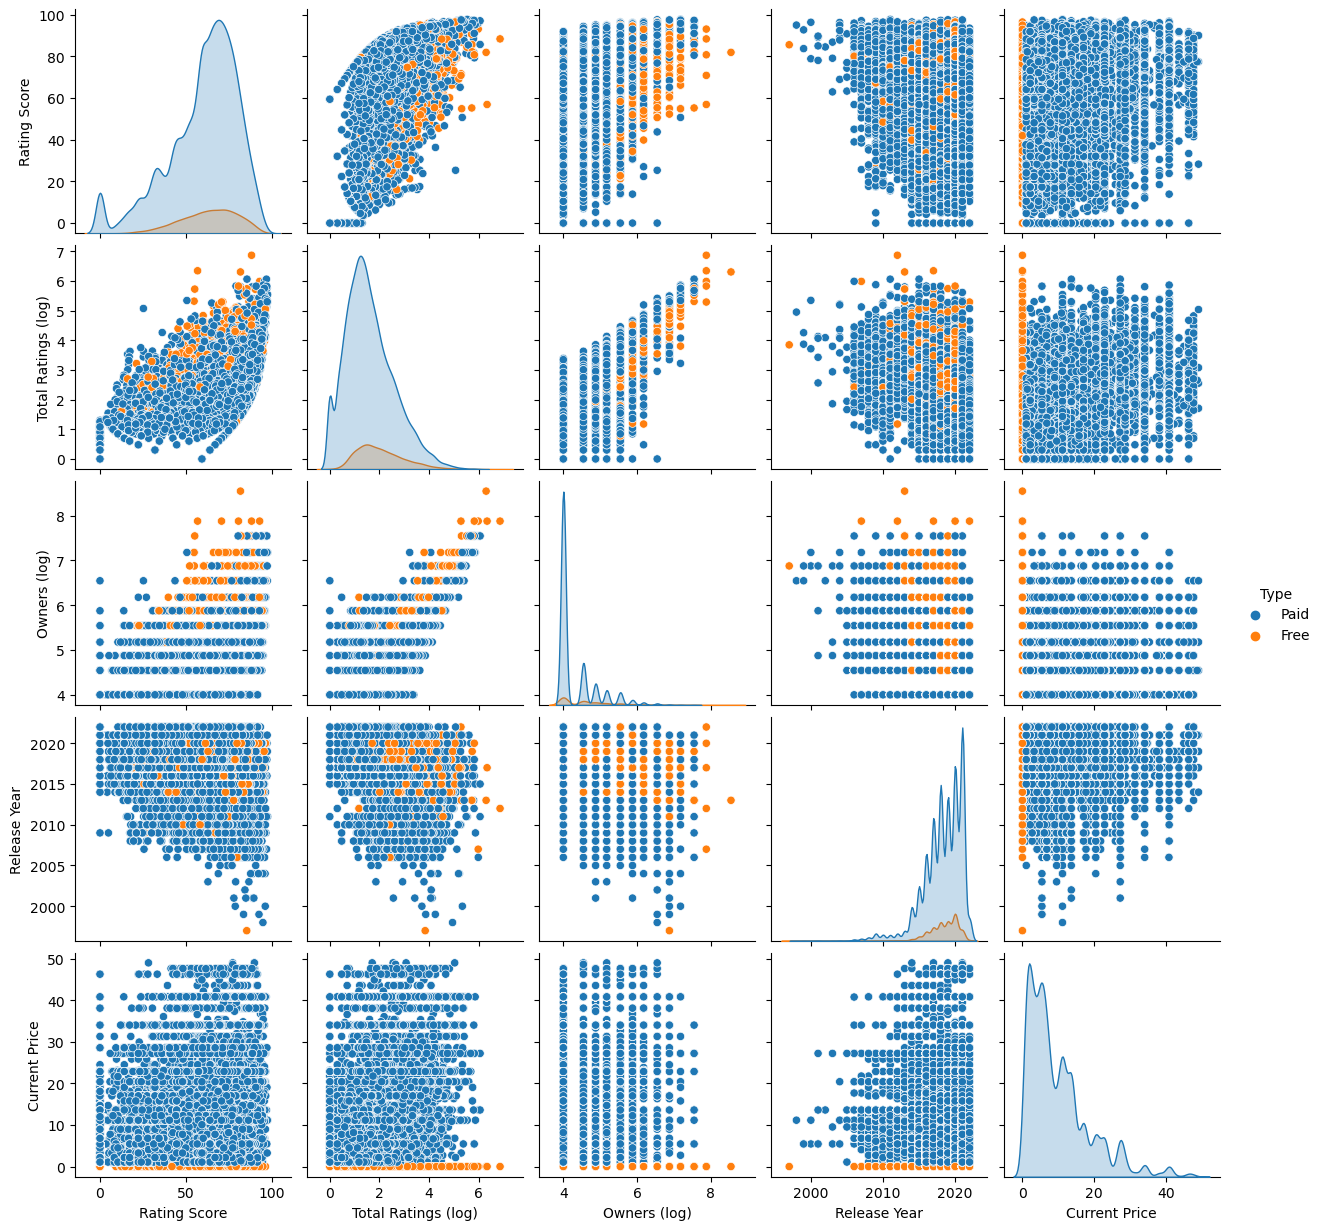

In [172]:
import warnings
warnings.filterwarnings('ignore')

#owners mid point
steam_analysis_data['owners_mid'] = (steam_analysis_data['owners_lower_estimation'] + steam_analysis_data['owners_upper_estimation']) / 2
steam_analysis_data['owners_mid'] = steam_analysis_data['owners_mid'].astype(int)

# ensure no 0s in columns we're applying log to
df = steam_analysis_data[(steam_analysis_data['owners_mid'] > 0) & (steam_analysis_data['total_ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners_mid']),
                          df['release_year'],
                          df.price_CAD,
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sns.pairplot(eda_df, hue='Type')
plt.show()

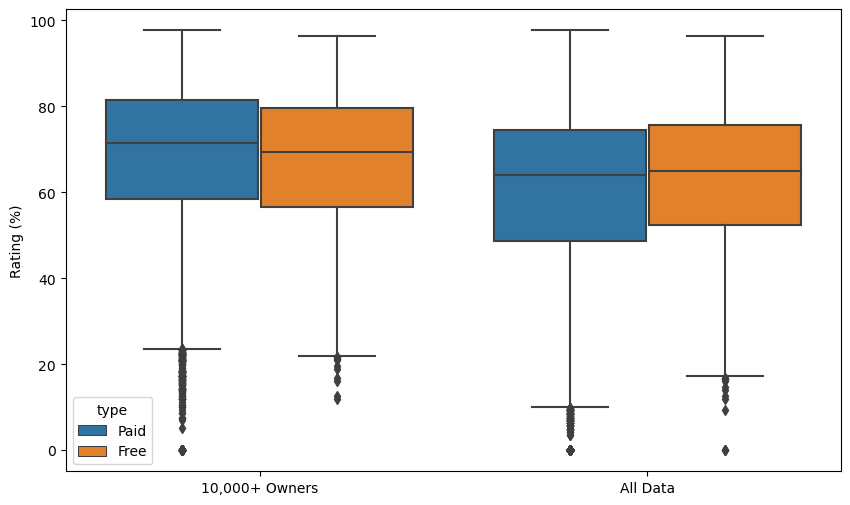

In [174]:
fig = plt.figure(figsize=(10,6))

dfa = steam_analysis_data[steam_analysis_data.owners_mid > 10000].copy()
dfa['subset'] = '10,000+ Owners'

dfb = steam_analysis_data.copy()
dfb['subset'] = 'All Data'

ax = sns.boxplot(x='subset', y='rating', hue='type', data=pd.concat([dfa, dfb]))

ax.set(xlabel='', ylabel='Rating (%)')
plt.show()

In [175]:
print(f'Games with fewer than 10,000 owners: {steam_analysis_data[steam_analysis_data.owners_mid <= 10000].shape[0]}\n',
      f'Games with more than 10,000 owners: {steam_analysis_data[steam_analysis_data.owners_mid > 10000].shape[0]}')

Games with fewer than 10,000 owners: 29369
 Games with more than 10,000 owners: 15877


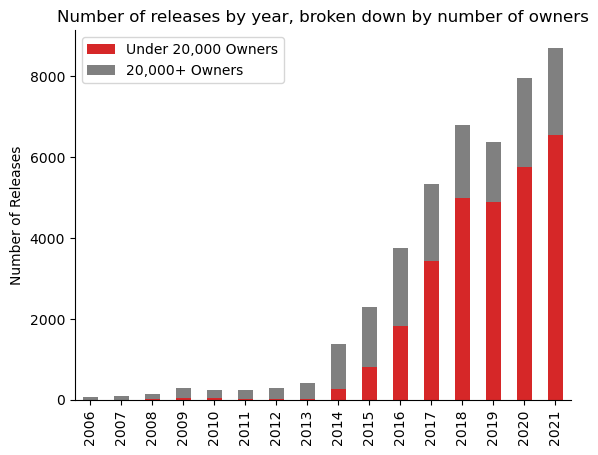

In [176]:
df = steam_analysis_data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2021:
        # very few releases in data prior to 2006, and data wa gathered in 2022 
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.owners_lower_estimation < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners_lower_estimation >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

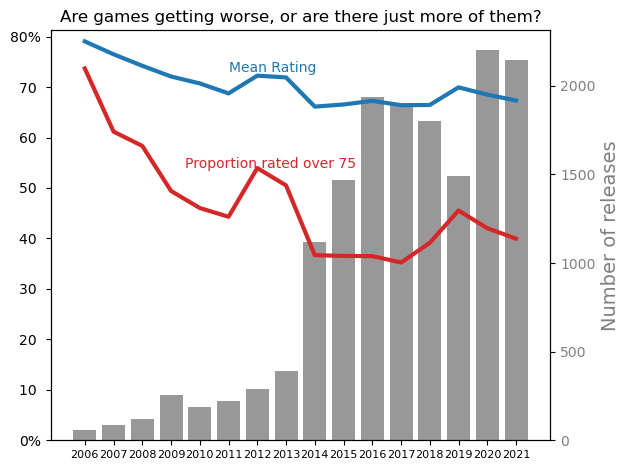

In [191]:
# Keeping games with only 20,000 owners or more
df = steam_analysis_data[steam_analysis_data.owners_lower_estimation >= 20000].copy()

rating_threshold = 75

years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []

# calculate values for plotting
for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2021:
        continue
    
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    n_high_rating = year_data[year_data['rating'] >= rating_threshold].shape[0]
    avg_rating = year_data['rating'].mean() / 100
    
    years.append(year)
    totals.append(total)
    proportions.append(n_high_rating/total)
    avg_ratings.append(avg_rating)
    
    # print(f'{year} | {n_high_rating/total:.2f}')
    
fig, ax1 = plt.subplots()

# ensure lines drawn over bars
ax1.set_zorder(1)
ax1.patch.set_visible(False)

# plot trendlines
ax1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
ax1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)

x_pos = np.arange(len(years))
ax1.set_xticks(x_pos)
ax1.set_xticklabels(years, fontsize=8)
ax1.set_yticks(np.arange(0, 0.9, 0.1))
ax1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

# instead of legend, place text directly over lines
ax1.text(5, 0.73, 'Mean Rating', color='tab:blue')
ax1.text(3.5, 0.54, 'Proportion rated over 75', color='tab:red')
# ax1.legend(loc='center', bbox_to_anchor=(0.5, 1.1))

# allow multiple axis on same plot
ax2 = ax1.twinx()

# plot number of releases by year
color = 'tab:gray'
ax2.bar(x_pos, totals, color=color, alpha=.8)

ax2.set_ylabel('Number of releases', color=color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Are games getting worse, or are there just more of them?')

fig.tight_layout()
plt.show()

In [178]:
import scipy.stats as stats
r, p_value = stats.pearsonr(totals, avg_ratings)

# using rating_ratio - pretty similar result
# stats.pearsonr(totals, df.groupby('release_year').mean().rating_ratio.loc[2006:2018].values)

print(f'Correlation coefficient (r): {r}\np-value: {p_value}')

Correlation coefficient (r): -0.764579625781817
p-value: 0.0005615765660493294


The r value of -0.76 indicates a moderately strong negative correlation.

# Top Games, Ratings and Genres

,name,developer,publisher,release_year,average_playtime,owners_mid,rating,price_CAD
25,Portal 2,Valve,Valve,2011,858,15000000,97.697361,11.152323
28779,People Playground,mestiez,Studio Minus,2019,4233,3500000,97.516031,11.152323
44619,Vampire Survivors,poncle,poncle,2021,1341,7500000,97.454051,3.254463
6674,Stardew Valley,ConcernedApe,ConcernedApe,2016,3549,15000000,97.313681,19.050183
29610,Hades,Supergiant Games,Supergiant Games,2020,1663,7500000,97.308988,28.582083
7192,Wallpaper Engine,Wallpaper Engine Team,Wallpaper Engine Team,2018,9333,35000000,97.237548,5.433183
14,Portal,Valve,Valve,2007,314,15000000,97.085068,11.152323
1109,Terraria,Re-Logic,Re-Logic,2011,6494,35000000,97.012228,13.603383
2920,RimWorld,Ludeon Studios,Ludeon Studios,2018,9104,3500000,96.783336,40.837383
20,Left 4 Dead 2,Valve,Valve,2009,2226,35000000,96.689345,11.152323


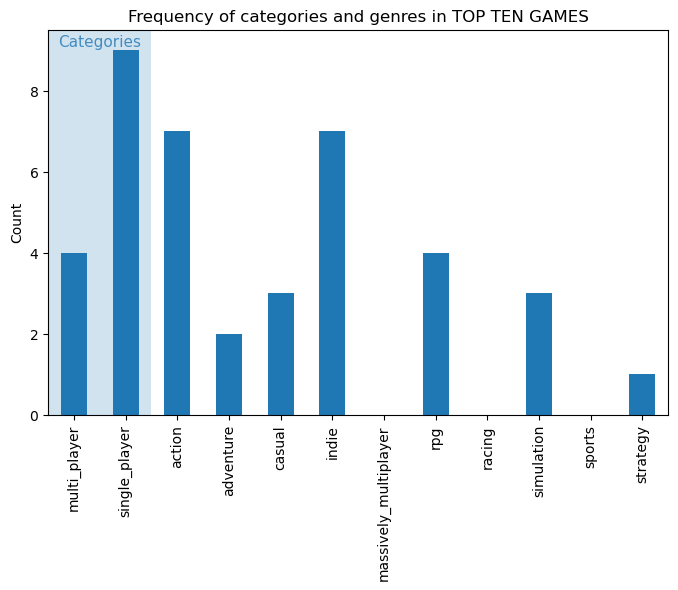

In [179]:
display_cols = ['name', 'developer', 'publisher', 'release_year', 'average_playtime', 'owners_mid', 'rating', 'price_CAD']
top_ten = df.sort_values(by='rating', ascending=False).head(10)

display(top_ten[display_cols])

# Storing category and genre columns in a variable
cat_gen_cols = df.columns[-14:-2]

# Renaming the category and genre columns
# new_genre_names = ['Multiplayer', 'Singleplayer', 'Action', 'Adventure', 'Casual',
#                    'Indie', 'Massively multiplayer', 'RPG', 'Racing', 'Simulation',
#                    'Sports', 'Strategy']

# top_ten = top_ten.rename(columns=dict(zip(cat_gen_cols, new_genre_names)))
# ax = top_ten[new_genre_names].sum().plot.bar(figsize=(8, 5))

ax = top_ten[cat_gen_cols].sum().plot.bar(figsize=(8, 5))

ax.fill_between([-.5, 1.5], 10, alpha=.2)
ax.text(0.5, 9.1, 'Categories', fontsize=11, color='tab:blue', alpha=.8, horizontalalignment='center')

ax.set_ylim([0, 9.5])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories and genres in TOP TEN GAMES')

plt.show()


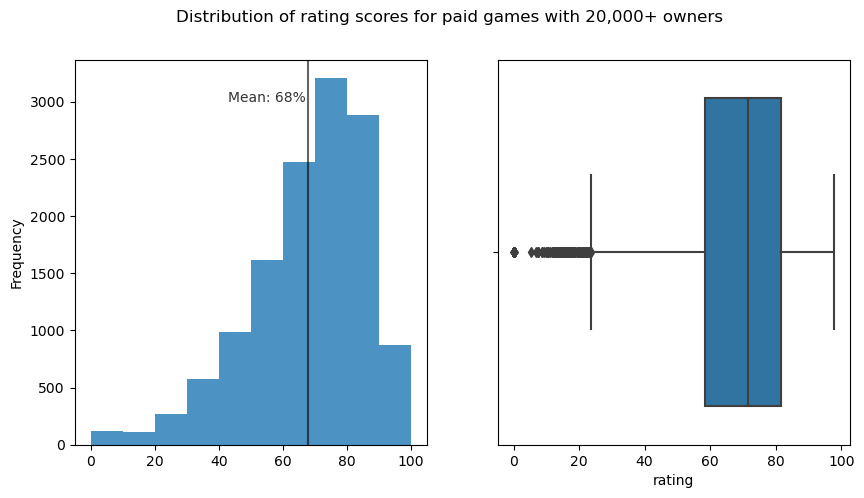

Mean rating: 67.97%


In [180]:
# paid with over 20,000 owners
df = steam_analysis_data[(steam_analysis_data.owners_lower_estimation >= 20000) & (steam_analysis_data.price_CAD > 0)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df.rating.plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)
# sns.distplot(df.rating, bins=range(0,100,10), ax=axarr[0])

# plot line for mean on histogram
mean = df.rating.mean()
axarr[0].axvline(mean, c='black', alpha=.6)
axarr[0].text(mean-1, 3000, f'Mean: {mean:.0f}%', c='black', ha='right', alpha=.8)


ax = sns.boxplot(x='rating', data=df, orient='v',ax=axarr[1])
fig.suptitle('Distribution of rating scores for paid games with 20,000+ owners')
plt.show()

print(f'Mean rating: {df.rating.mean():.2f}%')

In [182]:
gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])

f = stats.f_oneway(*(df.loc[df[g] == 1, 'rating'].values for g in gen_cols))
f

F_onewayResult(statistic=12.243883277027548, pvalue=1.450120203313272e-19)

Small p-value means that the null hypothesis is rejected. Rating variance is affected by genre variance.

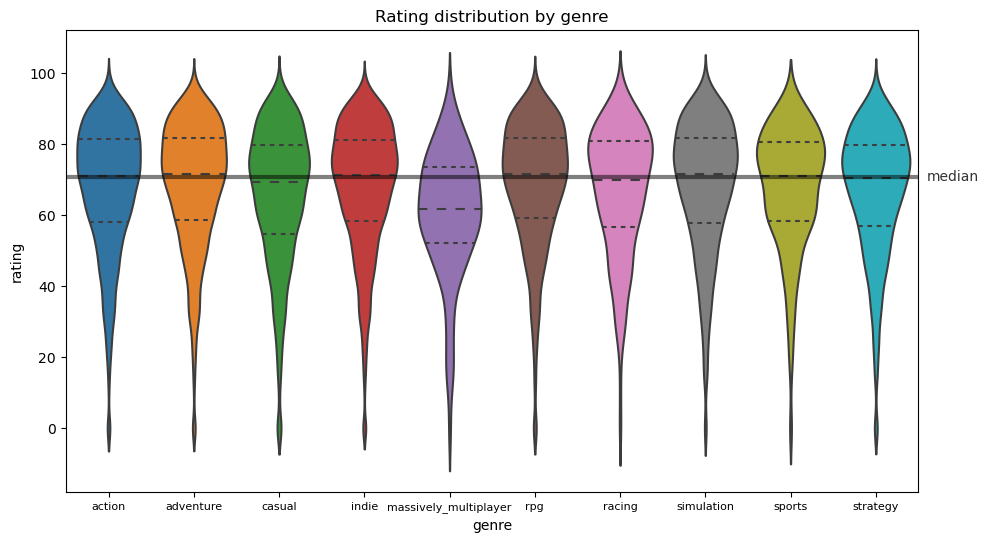

In [183]:
g_df = pd.DataFrame()

# create new dataframe with rating and genre, as games can belong to multiple genres
for col in gen_cols:
    ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].values, columns=['rating'])
    ratings['genre'] = col
    g_df = pd.concat([g_df, ratings], axis=0)

fig, ax = plt.subplots(figsize=(11,6))
sns.violinplot(x='genre', y='rating', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df.rating.median(), color='black', lw=3, alpha=.5)
ax.text(9.6, g_df.rating.median()-1, 'median', color='black', alpha=.8)

ax.tick_params(axis='x', labelsize=8)
ax.set_title("Rating distribution by genre");
plt.show()

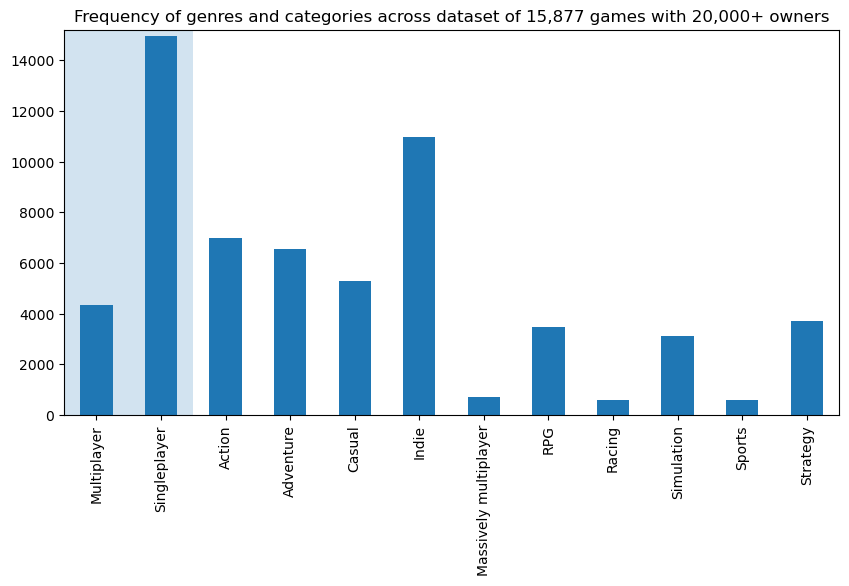

In [168]:
# over 20,000 owners
df = steam_analysis_data[steam_analysis_data.owners_lower_estimation >= 20000]

# Renaming the category and genre columns

new_genre_names = ['Multiplayer', 'Singleplayer', 'Action', 'Adventure', 'Casual',
                   'Indie', 'Massively multiplayer', 'RPG', 'Racing', 'Simulation',
                   'Sports', 'Strategy']

df = df.rename(columns=dict(zip(cat_gen_cols, new_genre_names)))

fig, ax = plt.subplots(figsize=(10,5))

df[new_genre_names].sum().plot.bar(ax=ax)

ax.fill_between([-.5, 1.5], 15200, alpha=.2)
ax.set_ylim([0, 15199])
ax.set_title(f'Frequency of genres and categories across dataset of {df.shape[0]:,} games with 20,000+ owners')

plt.show()

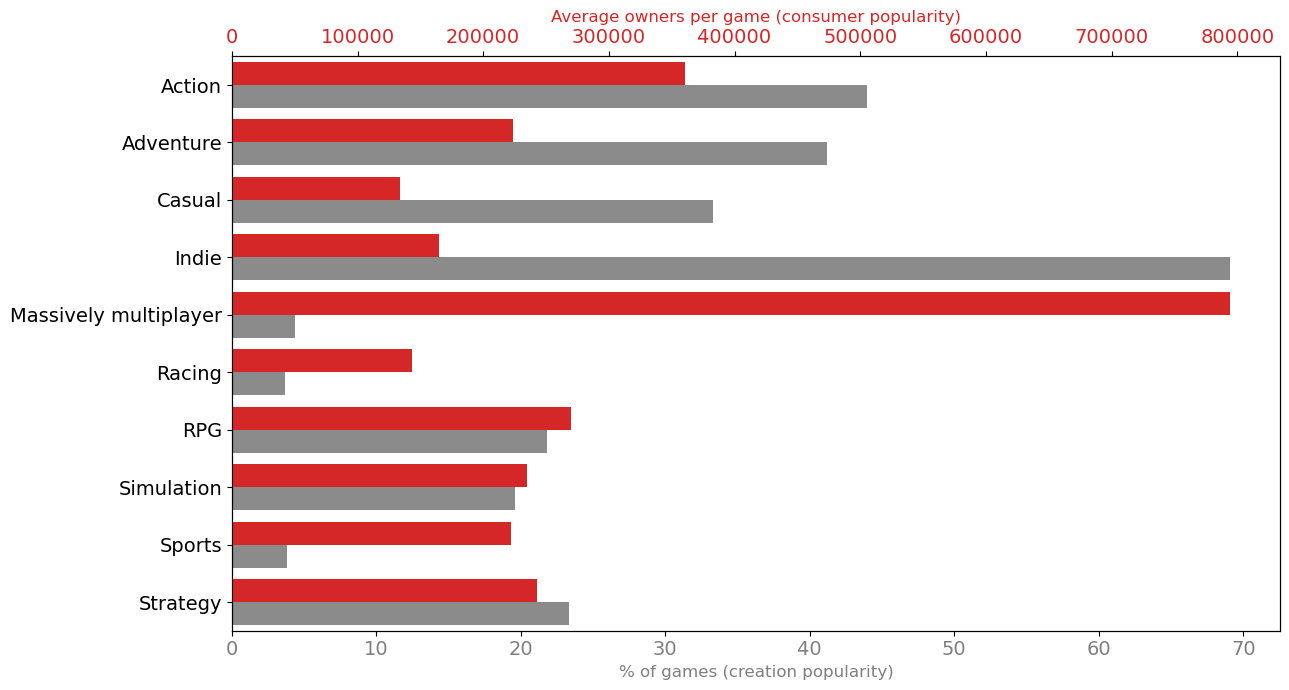

In [195]:
def plot_owners_comparison(df):
    genre_names = ['Action', 'Adventure', 'Casual', 'Indie', 'Massively multiplayer', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']
    genre_dict = {gen_cols[i]: genre_names[i] for i in range(len(gen_cols))}
    
    # percentage of games in each genre
    total_owners_per_genre = df[gen_cols].multiply(df['owners_lower_estimation'], axis='index').sum()
    average_owners_per_genre = total_owners_per_genre / df[gen_cols].sum()

    fig, ax1 = plt.subplots(figsize=(13, 7))

    color = 'tab:gray'
    (df[gen_cols].mean() * 100).sort_index(ascending=False).rename(genre_dict).plot.barh(ax=ax1, color=color, alpha=.9, position=1, fontsize=14, width=0.4)

    ax1.set_xlabel('% of games (creation popularity)', color=color, size=12)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.tick_params(axis='y', left='off', top='off')

    ax2 = ax1.twiny()

    color = 'tab:red'
    average_owners_per_genre.sort_index(ascending=False).rename(genre_dict).plot.barh(ax=ax2, color=color, alpha=1, position=0, fontsize=14, width=0.4)
    ax2.set_xlabel('Average owners per game (consumer popularity)', color=color, size=12)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_ylim([-.5, 9.5])

    plt.tight_layout()
    plt.show()

plot_owners_comparison(df)

In [189]:
df[df.owners_lower_estimation > 10000000]

,appid,name,release_date,developer,publisher,windows,mac,linux,required_age,genre,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners_lower_estimation,owners_upper_estimation,price_CAD,languages_sum,English,German,French,Simplified Chinese,Spanish,Russian,Japanese,Italian,Portuguese,Korean,Traditional Chinese,Polish,Turkish,Dutch,Czech,Swedish,Ukrainian,Hungarian,Arabic,Thai,Danish,Norwegian,Finnish,Romanian,Greek,Bulgarian,Vietnamese,release_year,total_ratings,rating_ratio,rating,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,type,owners_mid
20,550,Left 4 Dead 2,2009-11-16 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Zombies;Co-op;FPS,722891,18360,2226,565,20000000,50000000,11.152323,26,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,2009,741251,0.975231,96.689345,1,1,1,0,0,0,0,0,0,0,0,0,Paid,35000000
130,4000,Garry's Mod,2006-11-29 00:00:00+00:00,Facepunch Studios,Valve,True,True,True,0,Indie;Simulation,Sandbox;Multiplayer;Funny,931351,31912,10209,1382,20000000,50000000,13.603383,24,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,2006,963263,0.966871,95.923167,1,1,0,0,0,1,0,0,0,1,0,0,Paid,35000000
1109,105600,Terraria,2011-05-16 00:00:00+00:00,Re-Logic,Re-Logic,True,True,True,0,Action;Adventure;Indie;RPG,Open World Survival Craft;Sandbox;Survival,1112939,25657,6494,1972,20000000,50000000,13.603383,9,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1138596,0.977466,97.012228,1,1,1,1,0,1,0,1,0,0,0,0,Paid,35000000
1441,218620,PAYDAY 2,2013-08-13 00:00:00+00:00,OVERKILL - a Starbreeze Studio.,Starbreeze Publishing AB,True,False,True,18,Action;RPG,Co-op;Action;FPS,556709,66480,14925,556,20000000,50000000,13.603383,11,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2013,623189,0.893323,88.527608,1,1,1,0,0,0,0,1,0,0,0,0,Paid,35000000
1784,242760,The Forest,2018-04-30 00:00:00+00:00,Endnight Games Ltd,Endnight Games Ltd,True,False,False,0,Action;Adventure;Indie;Simulation,Open World Survival Craft;Survival;Open World,460518,22011,1436,769,20000000,50000000,22.862943,16,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,2018,482529,0.954384,94.509909,1,1,1,1,0,1,0,0,0,1,0,0,Paid,35000000
4441,346110,ARK: Survival Evolved,2017-08-27 00:00:00+00:00,"Studio Wildcard, Instinct Games, Efecto Studio...",Studio Wildcard,True,True,True,0,Action;Adventure;Indie;Massively Multiplayer;RPG,Open World Survival Craft;Survival;Multiplayer,525377,110609,9840,1748,20000000,50000000,34.028883,21,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,0,0,0,2017,635986,0.826083,81.868691,1,1,1,1,0,1,1,1,0,0,0,0,Paid,35000000
4918,359550,Tom Clancy's Rainbow Six Siege,2015-12-01 00:00:00+00:00,Ubisoft Montreal,Ubisoft,True,False,False,0,Action,FPS;Hero Shooter;Multiplayer,985934,156209,13418,2510,20000000,50000000,27.220383,16,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,2015,1142143,0.863232,85.675216,1,1,1,0,0,0,0,0,0,0,0,0,Paid,35000000
7192,431960,Wallpaper Engine,2018-11-01 00:00:00+00:00,Wallpaper Engine Team,Wallpaper Engine Team,True,False,False,0,Casual;Indie;Animation & Modeling;Design & Ill...,Mature;Utilities;Software,643982,12422,9333,965,20000000,50000000,5.433183,22,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,0,2018,656404,0.981076,97.237548,0,0,0,0,1,1,0,0,0,0,0,0,Paid,35000000
21985,892970,Valheim,2021-02-02 00:00:00+00:00,Iron Gate AB,Coffee Stain Publishing,True,False,True,0,Action;Adventure;Indie;RPG;Early Access,Open World Survival Craft;Survival;Online Co-Op,385749,20672,3121,1533,20000000,50000000,22.862943,12,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2021,406421,0.949136,93.941286,1,1,1,1,0,1,0,1,0,0,0,0,Paid,35000000
23531,945360,Among Us,2018-11-16 00:00:00+00:00,Innersloth,Innersloth,True,False,False,0,Casual,Multiplayer;Online Co-Op;Social Deduction,607564,54296,1906,800,20000000,50000000,5.433183,12,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2018,661860

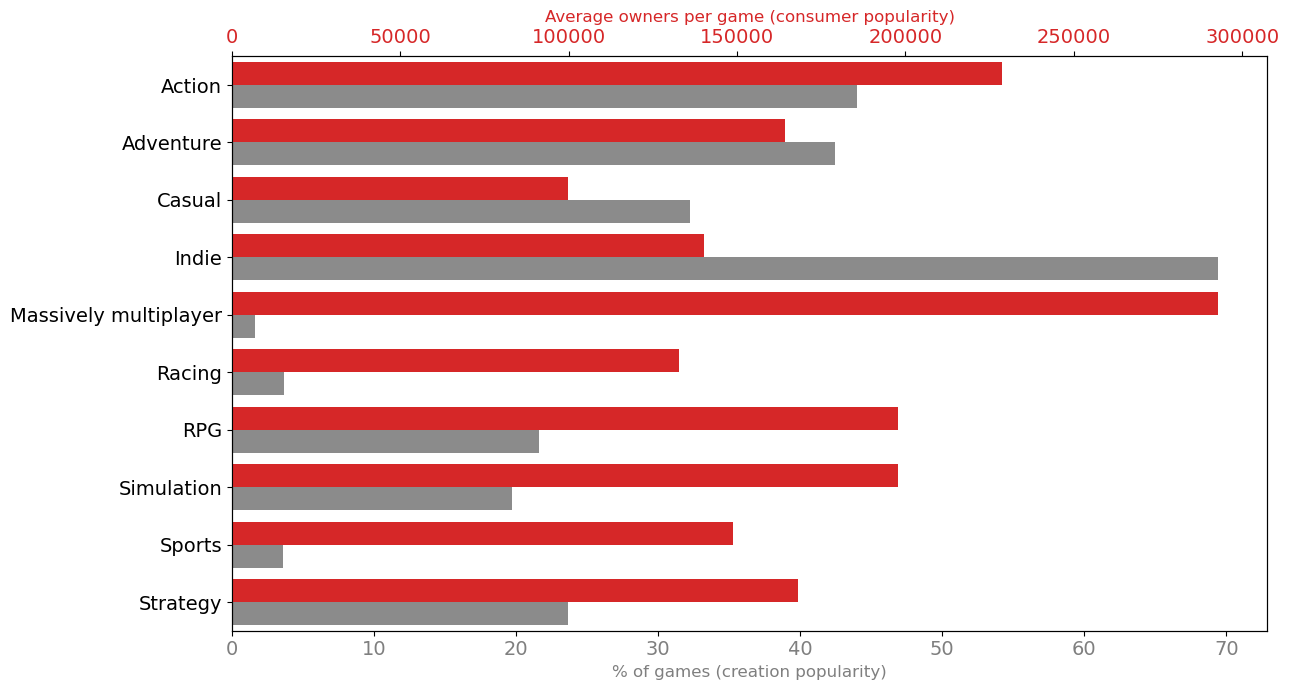

In [231]:
#games with 10,000,000 owners or less and paid
plot_owners_comparison(df[(df.owners_lower_estimation <= 10000000) & (df.price_CAD > 0)])

# Owners, Pricing and Ratings

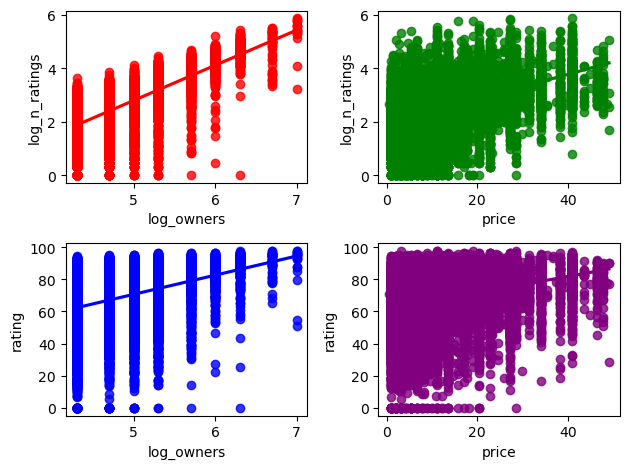

In [247]:
log_df = pd.DataFrame(zip(np.log10(df3.owners_lower_estimation), np.log10(df3.total_ratings), df3.rating, df3.price_CAD),
                      columns=['log_owners', 'log_n_ratings', 'rating', 'price'])

fig, axarr = plt.subplots(2, 2)

sns.regplot(x='log_owners', y='log_n_ratings', data=log_df, ax=axarr[0][0], color='red')
sns.regplot(x='log_owners', y='rating', data=log_df, ax=axarr[1][0], color='blue')
sns.regplot(x='price', y='log_n_ratings', data=log_df, ax=axarr[0][1], color='green')
sns.regplot(x='price', y='rating', data=log_df, ax=axarr[1][1], color='purple')

plt.tight_layout()
plt.show()

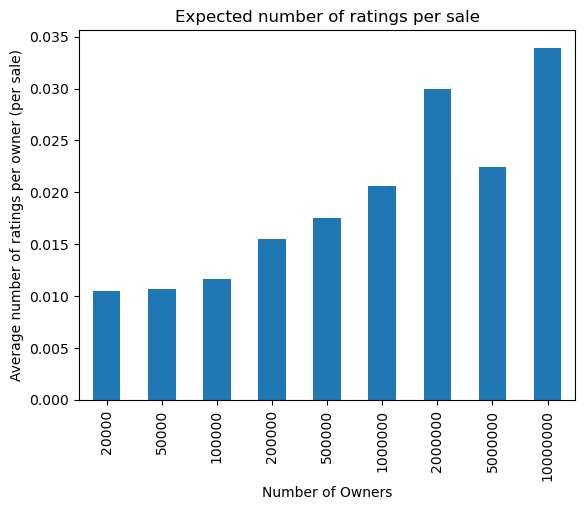

In [245]:
df2 = df.copy()
df2 = df2[(df2['owners_lower_estimation'] <= 10000000) & (df2['price_CAD'] > 0)]

grp = df2.groupby('owners_lower_estimation')

ax = (grp['total_ratings'].mean() / sorted(df2['owners_lower_estimation'].unique())).plot.bar()
ax.set_ylabel('Average number of ratings per owner (per sale)')
ax.set_xlabel('Number of Owners')
ax.set_title('Expected number of ratings per sale');

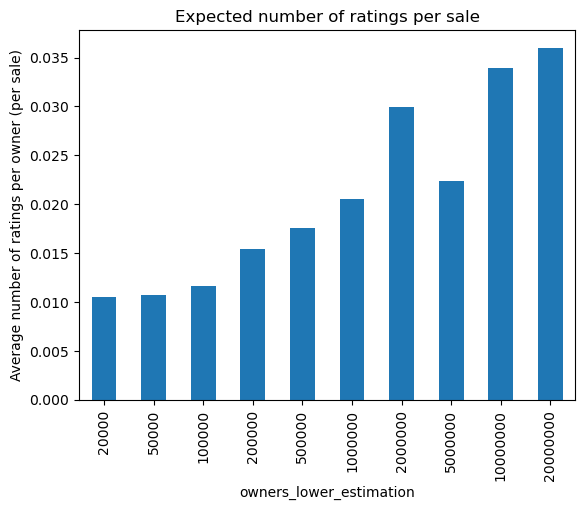

In [74]:
grp = df.groupby('owners_lower_estimation')

ax = (grp['total_ratings'].mean() / sorted(df['owners_lower_estimation'].unique())).plot.bar()
ax.set_ylabel('Average number of ratings per owner (per sale)')
ax.set_title('Expected number of ratings per sale');

# Pricing

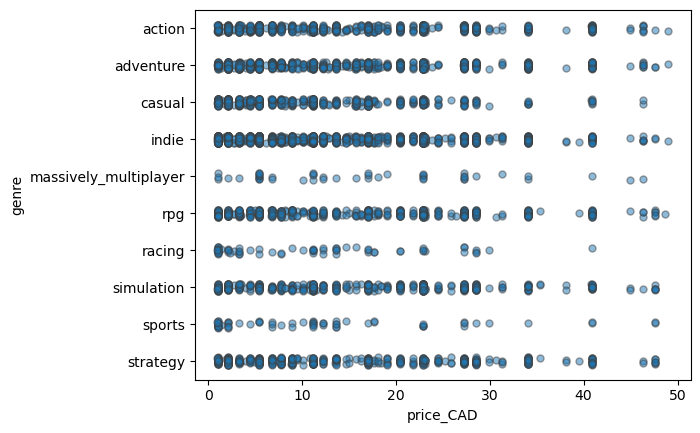

In [76]:
g_df = pd.DataFrame()

for col in gen_cols:
    temp_df = df[df[col] == 1].copy()
    temp_df['genre'] = col
    g_df = pd.concat([g_df, temp_df], axis=0)


recent_df = g_df[g_df['release_year'] >= 2021].copy()
ax = sns.stripplot(x='price_CAD', y='genre', data=recent_df, jitter=True, alpha=.5, linewidth=1);

# Developers and Publishers

In [77]:
pv = df.pivot_table(index='developer', 
               values=['appid', 'rating'], 
               aggfunc={'appid':'count', 'rating':np.mean})

pv = pv.rename({'appid':'num_releases'}, axis=1).sort_values(by='rating', ascending=False)

pv.head()

,num_releases,rating
developer,,
mestiez,1,97.516031
poncle,1,97.454051
ConcernedApe,1,97.313681
Wallpaper Engine Team,1,97.237548
Re-Logic,1,97.012228


In [78]:
def get_scores(df):
    # extracting values
    num_releases = df.num_releases**(1/2)
    log_owners = np.log10(df.sum_owners)
    mean_rating = df.mean_rating
    log_ratings = np.log10(df.total_ratings)
    
    # calculating z scores
    z_num_releases = stats.zscore(num_releases)
    z_log_owners = stats.zscore(log_owners)
    z_mean_rating = stats.zscore(mean_rating)
    z_log_ratings = stats.zscore(log_ratings)

    # calculate score (per row)
    # half owners and number of ratings, because allude to the same thing
    # give smaller weight to number of releases
    # rating most important, give highest weighting
    scores = (.1*z_num_releases + .5*.2*z_log_owners + .5*z_mean_rating + .5*.25*z_log_ratings) / 3
        
    return scores

pv_df = df.copy()
pv_df['num_releases'] = 1
pv = pv_df.pivot_table(index='developer',
                       values=['num_releases', 'owners_lower_estimation', 'rating', 'total_ratings', 'price_CAD'],
                       aggfunc={'num_releases': np.sum,
                                'owners_lower_estimation': np.sum, 
                                'rating': np.mean,
                                'total_ratings': np.sum,
                                'price_CAD': np.mean}
                      ).rename({'owners_lower_estimation': 'sum_owners', 
                                'price_CAD': 'mean_price',
                                'rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)
pv = pv.sort_values(by='score', ascending=False)
pv.head(10)

,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score
developer,,,,,,
Valve,19,114000000,9.417947,88.950632,2046284,0.782488
Quiet River,23,2430000,1.620423,87.078935,70849,0.650386
"CAPCOM Co., Ltd.",15,24520000,31.396263,82.726384,711450,0.630448
"PopCap Games, Inc.",21,3980000,6.794883,84.287513,133037,0.629854
Square Enix,24,8840000,24.014714,76.501123,226030,0.611637
Ubisoft Montreal,17,29150000,16.607133,75.844039,1284837,0.600952
id Software,17,10700000,14.644683,80.816539,274430,0.596846
Klei Entertainment,9,13700000,20.472403,88.021476,535230,0.590012
Daedalic Entertainment,20,5570000,24.837408,77.951463,57270,0.556517


Add names of top games from each developer

In [79]:
def get_top_games(pv, col):
    pv = pv.copy()
    for pv_name in pv.index:
        top_games = df[df[col] == pv_name].sort_values(by='rating', ascending=False).name

        top_5 = [n for n in top_games[:5]]

        pv.loc[pv_name, 'top_games'] = ', '.join(top_5)
        
    return pv
    
pv_top_ten_devs = get_top_games(pv.head(10), 'developer')

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_devs[['score', 'top_games']])

,score,top_games
developer,,
Valve,0.782488,"Portal 2, Portal, Left 4 Dead 2, Counter-Strike, Half-Life 2"
Quiet River,0.650386,"Zup! S, Zup! F, Zup! X, Zup! Z, Zup! 8"
"CAPCOM Co., Ltd.",0.630448,"Phoenix Wright: Ace Attorney Trilogy, Devil May Cry 5, Resident Evil 7 Biohazard, Resident Evil, Okami HD"
"PopCap Games, Inc.",0.629854,"Plants vs. Zombies GOTY Edition, Peggle Deluxe, Insaniquarium Deluxe, Bejeweled 3, Feeding Frenzy 2 Deluxe"
Square Enix,0.611637,"FINAL FANTASY IX, FINAL FANTASY VII, FINAL FANTASY, FINAL FANTASY III, FINAL FANTASY X/X-2 HD Remaster"
Ubisoft Montreal,0.600952,"Tom Clancy's Splinter Cell Chaos Theory, Assassin's Creed 2, Assassin’s Creed Brotherhood, Far Cry 3 - Blood Dragon, Tom Clancy's Rainbow Six Siege"
id Software,0.596846,"DOOM, DOOM (1993), DOOM II, Quake III Arena, Wolfenstein 3D"
Klei Entertainment,0.590012,"Oxygen Not Included, Don't Starve Together, Mark of the Ninja: Remastered, Griftlands, Hot Lava"
Daedalic Entertainment,0.556517,"Ken Follett's The Pillars of the Earth, Chaos on Deponia, The Night of the Rabbit, The Dark Eye: Memoria, Edna & Harvey: Harvey's New Eyes"


By wrapping the previous tasks in funcions, we can easily repeat the process for publishers:

In [80]:
pv = pv_df.pivot_table(index='publisher',
                       values=['num_releases', 'owners_lower_estimation', 'rating', 'total_ratings', 'price_CAD'],
                       aggfunc={'num_releases': np.sum,
                                'owners_lower_estimation': np.sum, 
                                'rating': np.mean,
                                'total_ratings': np.sum,
                                'price_CAD': np.mean}
                      ).rename({'owners_lower_estimation': 'sum_owners', 
                                'price_CAD': 'mean_price',
                                'rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)

pv_top_ten_pubs = get_top_games(pv.sort_values(by='score', ascending=False).head(10), col='publisher')

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_pubs)

,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score,top_games
publisher,,,,,,,
Ubisoft,86,60880000,19.889370,75.080005,2051298,0.751810,"South Park: The Stick of Truth, Valiant Hearts: The Great War / Soldats Inconnus : Mémoires de la Grande Guerre, Rayman Origins, Trackmania United Forever, Child of Light"
Devolver Digital,73,28410000,18.093262,81.900969,788693,0.746654,"Katana ZERO, Hotline Miami, Inscryption, Broforce, GRIS"
SEGA,79,31220000,19.708625,79.772636,525877,0.739516,"Persona 4 Golden, Yakuza 0, Warhammer 40,000: Dawn of War - Dark Crusade, Warhammer 40,000: Dawn of War - Soulstorm, Yakuza Kiwami 2"
Valve,22,141000000,9.245943,89.441690,3040734,0.690470,"Portal 2, Portal, Left 4 Dead 2, Counter-Strike, Half-Life 2"
THQ Nordic,96,21040000,20.203373,70.262502,285204,0.677263,"SpongeBob SquarePants: Battle for Bikini Bottom - Rehydrated, Gothic II: Gold Edition, Impossible Creatures Steam Edition, Destroy All Humans!, Gothic 1"
Electronic Arts,47,34750000,28.715356,81.259870,705355,0.663387,"Titanfall 2, Super Meat Boy, Dead Space 2, Mass Effect 2 (2010 Edition), Command & Conquer 3: Kane's Wrath"
Bethesda Softworks,35,51100000,21.968112,82.205712,1698689,0.649970,"Dishonored, Fallout: New Vegas, DOOM, The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion Game of the Year Edition"
Square Enix,63,22880000,20.887397,73.106003,508262,0.625571,"PowerWash Simulator, Supreme Commander: Forged Alliance, FINAL FANTASY IX, FINAL FANTASY VII, FINAL FANTASY"
Xbox Game Studios,32,27860000,24.624642,82.567037,726415,0.613528,"Ori and the Will of the Wisps, Age of Empires II (2013), Ori and the Blind Forest: Definitive Edition, Age of Empires II: Definitive Edition, Dust: An Elysian Tail"


# Correlations

In [204]:
df[df['owners_lower_estimation'] >= 10000000]

,appid,name,release_date,developer,publisher,windows,mac,linux,required_age,genre,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners_lower_estimation,owners_upper_estimation,price_CAD,languages_sum,English,German,French,Simplified Chinese,Spanish,Russian,Japanese,Italian,Portuguese,Korean,Traditional Chinese,Polish,Turkish,Dutch,Czech,Swedish,Ukrainian,Hungarian,Arabic,Thai,Danish,Norwegian,Finnish,Romanian,Greek,Bulgarian,Vietnamese,release_year,total_ratings,rating_ratio,rating,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,type,owners_mid
2,10,Counter-Strike,2000-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,214651,5470,7720,232,10000000,20000000,11.152323,8,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,220121,0.975150,96.313460,1,0,1,0,0,0,0,0,0,0,0,0,Paid,15000000
12,320,Half-Life 2: Deathmatch,2004-11-01 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Action;FPS;Multiplayer,10605,1112,903,36,10000000,20000000,5.433183,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004,11717,0.905095,87.812911,1,0,1,0,0,0,0,0,0,0,0,0,Paid,15000000
14,400,Portal,2007-10-10 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Puzzle;Puzzle-Platformer;First-Person,130172,1982,314,182,10000000,20000000,11.152323,25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,2007,132154,0.985002,97.085068,0,1,1,0,0,0,0,0,0,0,0,0,Paid,15000000
18,440,Team Fortress 2,2007-10-10 00:00:00+00:00,Valve,Valve,True,True,True,0,Action;Free to Play,Free to Play;Hero Shooter;Multiplayer,898809,59503,10425,352,50000000,100000000,0.000000,25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,2007,958312,0.937909,93.048659,1,0,1,0,0,0,0,0,0,0,0,0,Free,75000000
20,550,Left 4 Dead 2,2009-11-16 00:00:00+00:00,Valve,Valve,True,True,True,0,Action,Zombies;Co-op;FPS,722891,18360,2226,565,20000000,50000000,11.152323,26,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,2009,741251,0.975231,96.689345,1,1,1,0,0,0,0,0,0,0,0,0,Paid,35000000
21,570,Dota 2,2013-07-09 00:00:00+00:00,Valve,Valve,True,True,True,0,Action;Free to Play;Strategy,Free to Play;MOBA;Multiplayer,1643520,350932,43659,755,200000000,500000000,0.000000,26,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,2013,1994452,0.824046,81.881610,1,0,1,0,0,0,0,0,0,0,0,1,Free,350000000
22,730,Counter-Strike: Global Offensive,2012-08-21 00:00:00+00:00,"Valve, Hidden Path Entertainment",Valve,True,True,True,0,Action;Free to Play,FPS;Shooter;Multiplayer,6454163,820447,35229,6401,50000000,100000000,0.000000,26,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,2012,7274610,0.887218,88.340366,1,0,1,0,0,0,0,0,0,0,0,0,Free,75000000
25,620,Portal 2,2011-04-18 00:00:00+00:00,Valve,Valve,True,True,True,0,Action;Adventure,Platformer;Puzzle;Dark Humor,340722,4277,858,537,10000000,20000000,11.152323,25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,2011,344999,0.987603,97.697361,1,1,1,1,0,0,0,0,0,0,0,0,Paid,15000000
130,4000,Garry's Mod,2006-11-29 00:00:00+00:00,Facepunch Studios,Valve,True,True,True,0,Indie;Simulation,Sandbox;Multiplayer;Funny,931351,31912,10209,1382,20000000,50000000,13.603383,24,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,2006,963263,0.966871,95.923167,1,1,0,0,0,1,0,0,0,1,0,0,Paid,35000000
227,8930,Sid Meier's Civilization V,2010-09-23 00:00:00+00:00,"Firaxis Games, Aspyr (Mac), Aspyr (Linux)","2K, Aspyr (Mac), Aspyr (Linux)",True,True,True,0,Strategy,Turn-Based Strategy;Strategy;Turn-Based,184646,7405,7707,1886,10000000,20000000,40.837383,10,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,192051,0.961443,94.909939,1,1,0,0,0,0,0,0,0,0,0,1,Paid,15000000


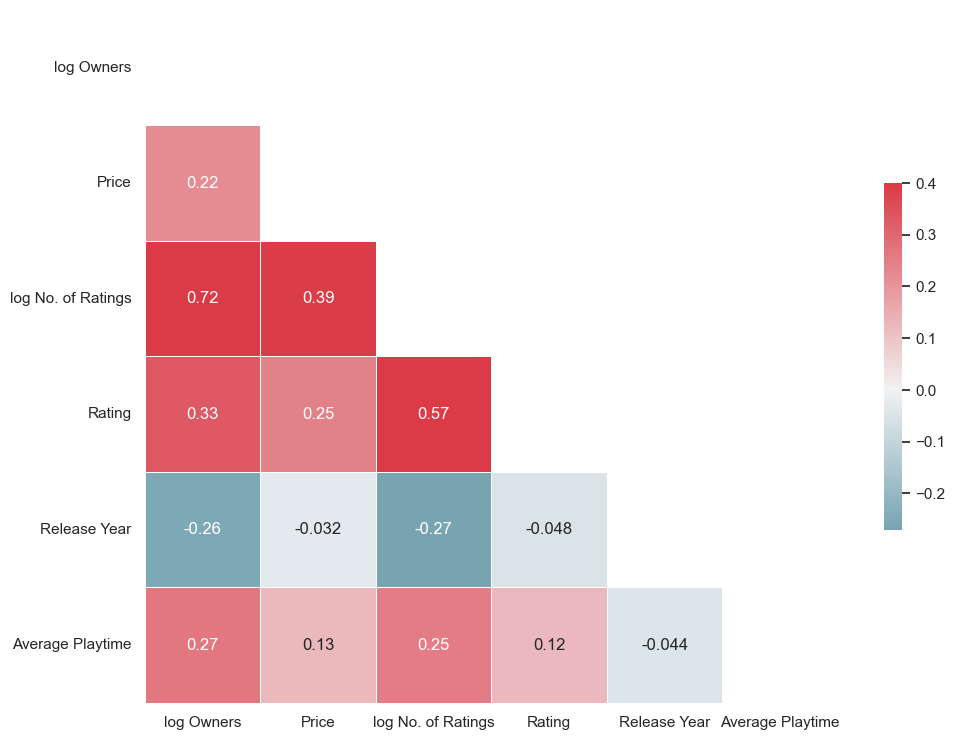

In [227]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(12,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.4, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    
    plt.yticks(rotation=0)
    plt.show()
    plt.rcdefaults()

corr_df = df.copy()

# Rename columns using a dictionary
new_column_names = {'price_CAD': 'Price', 
                    'rating': 'Rating', 
                    'release_year': 'Release Year', 
                    'average_playtime': 'Average Playtime',
                    'languages_sum': 'No. of Languages'}

corr_df = corr_df.rename(columns=new_column_names)

corr_df['log Owners'] = np.log10(corr_df['owners_lower_estimation'])
corr_df['log No. of Ratings'] = np.log10(corr_df['total_ratings'])

plot_correlation_heatmap(corr_df[['log Owners', 'Price', 'log No. of Ratings', 'Rating', 'Release Year', 'Average Playtime']])

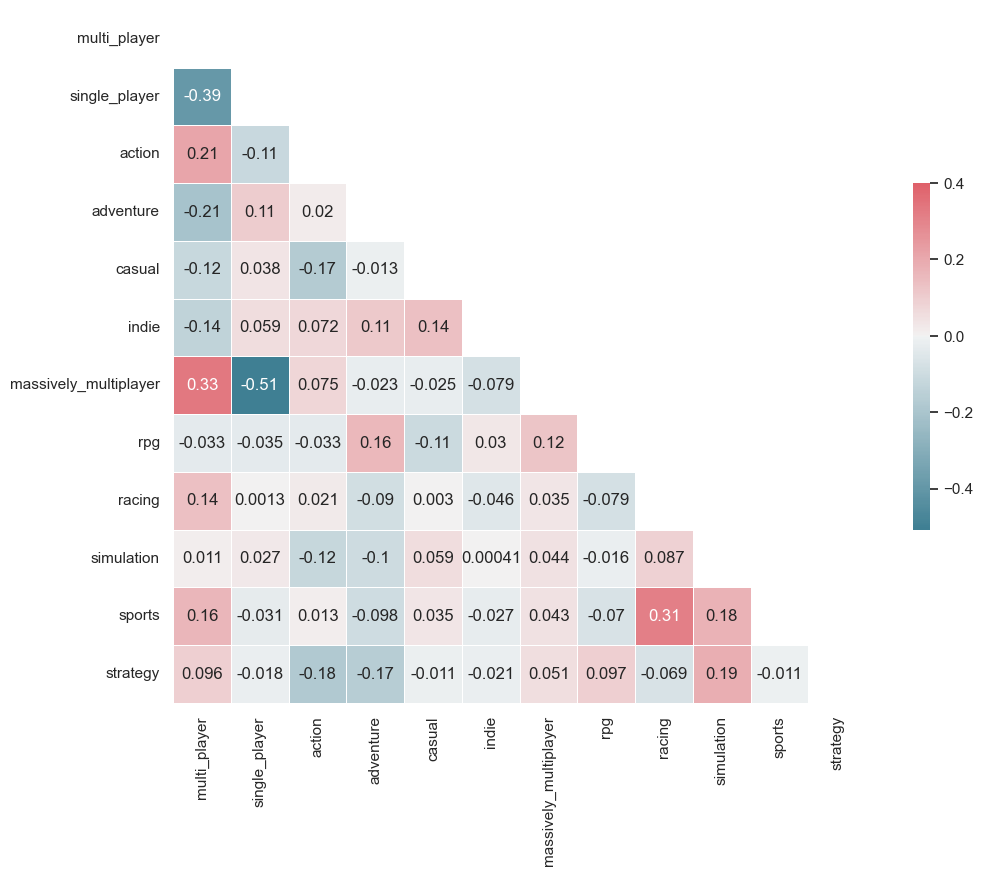

In [228]:
plot_correlation_heatmap(corr_df[cat_gen_cols])

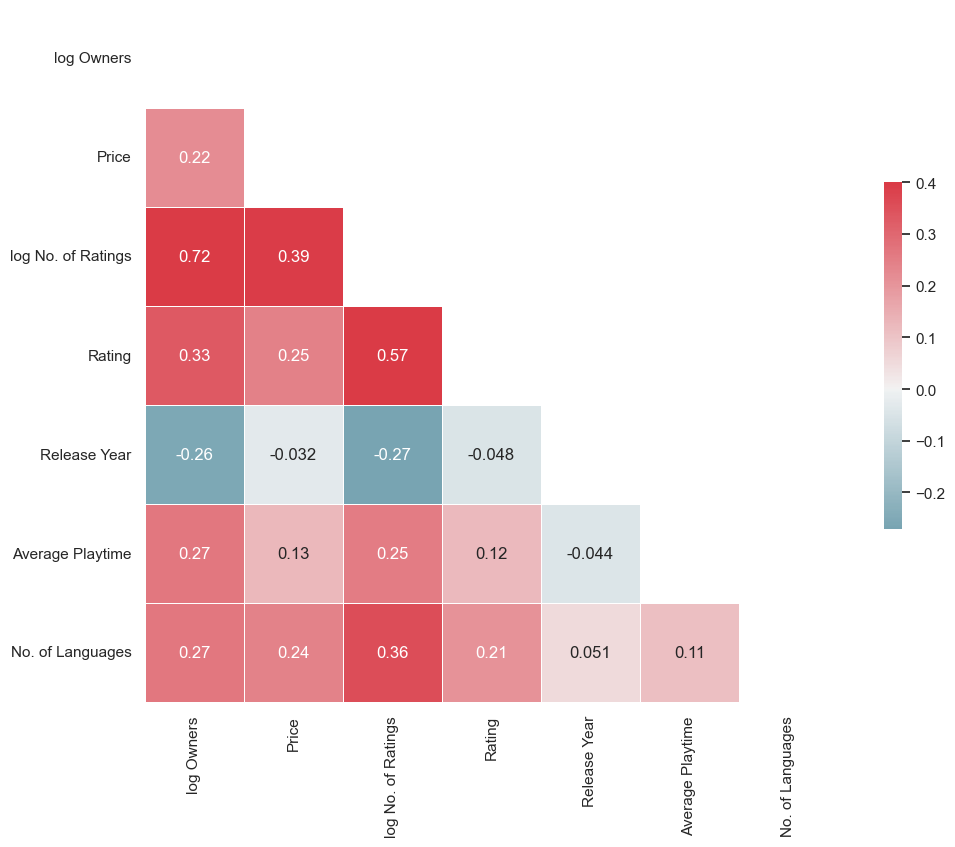

In [229]:
plot_correlation_heatmap(corr_df[['log Owners', 
                                  'Price', 
                                  'log No. of Ratings', 
                                  'Rating', 
                                  'Release Year', 
                                  'Average Playtime', 
                                  'No. of Languages']])